# COMP 596 Programming Assignment 2
#### Hong, Joon Hwan (260832806)

## Bookmarks
### Section for:
1) <a href=#1>Simulation class</a>

2) <a href=#2>Class Functions</a>

3) <a href=#3>Algorithms</a>

4) <a href=#4>Experiments</a>

In [342]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d

In [343]:
# RNG Seeds
random.seed(596)
np.random.seed(596)

In [344]:
####################################################################################################
# watermaze module
####################################################################################################
class watermaze(object):
    
    """
    This class defines a set of functions for simulating a rat moving in a water-maze.
    
    For the purposes of this assignment, you should be using the move function to 
    determine the next state of the environment at each time-step of the simulation.
    
    See the demo of its usage after the module code.
    """
    
    ####################################################################
    # the initialization function, measurements are in cm
    def __init__(self, pool_radius=60, platform_radius=10, platform_location=np.array([25,25]), 
                 stepsize=5.0, momentum=0.2, T=60):
        
        """
        The init function for the watermaze module.
        
        - The pool_radius argument specifies the radius of the pool.
        
        - The platform_radius argument specifies the radius of the platform.
        
        - The platform_location argument specifies the location of the platform centre.
        
        - The stepsize argument specifies how far the rat moves in one step.
        
        - The momentum argument specifies the ratio of old movement to new movement direction (i.e. 
        momentum = 0 means all new movement, momentum = 1 means all old movement, otherwise a mix.
        
        - The T argument is the maximum time for a trial in the pool.

        
        """
        
        # store the given info
        self.radius            = pool_radius
        self.platform_radius   = platform_radius
        self.platform_location = platform_location
        self.stepsize          = stepsize
        self.momentum          = momentum
        self.T                 = T
        
        # a dictionary for calculating directions
        self.direction = {
            0:  np.pi/2, #north
            1:  np.pi/4, #north-east
            2:  0, #east
            3:  7*np.pi/4, #south-east
            4:  3*np.pi/2, #south
            5:  5*np.pi/4, #south-west
            6:  np.pi, #west
            7:  3*np.pi/4, #north-west
        }
        
        # initialize the dynamic variables
        self.position = np.zeros((2,T))
        self.t        = 0
        self.prevdir  = np.zeros((2,))
        
    ####################################################################
    # for updating the rat's position in the pool
    def move(self, A):

        """
        Updates the simulated rat's position in the water-maze environment by moving it in the 
        specified direction. 
        
        - The argument A is the last selected action, and must be an integer from 0-7, with 0 indicating N, 
        1 indicating NE, etc. 

        """
        
        # check the A argument
        if (not np.isin(A, np.arange(8))):
            print('Error: The argument A must be an integer from 0-7, indicating which action was selected.')

        # determine the vector of direction of movement
        angle = self.direction[A]
        newdirection = np.array([np.cos(angle), np.sin(angle)])
        
        # add in momentum to reflect actual swimming dynamics (and normalize, then multiply by stepsize)
        direction = (1.0 - self.momentum)*newdirection + self.momentum*self.prevdir
        direction = direction/np.sqrt((direction**2).sum())
        direction = direction*self.stepsize
        
        # update the position, prevent the rat from actually leaving the water-maze by having it "bounce" off the wall 
        [newposition, direction] = self.poolreflect(self.position[:,self.t] + direction)

        # if we're now at the very edge of the pool, move us in a little-bit
        if (np.linalg.norm(newposition) == self.radius):
            newposition = np.multiply(np.divide(newposition,np.linalg.norm(newposition)),(self.radius - 1))

        # update the position, time (and previous direction)
        self.position[:,self.t+1] = newposition
        self.t                    = self.t + 1
        self.prevdir              = direction
        
    ####################################################################
    # for bouncing the rat off the wall of the pool
    def poolreflect(self, newposition):
        
        """
        The poolreflect function returns the point in space at which the rat will be located if it 
        tries to move from the current position to newposition but bumps off the wall of the pool. 
        If the rat would not bump into the wall, then it simply returns newposition. The function 
        also returns the direction the rat will be headed.
        """

        # determine if the newposition is outside the pool, if not, just return the new position
        if (np.linalg.norm(newposition) < self.radius):
            refposition  = newposition
            refdirection = newposition - self.position[:,self.t]

        else:

            # determine where the rat will hit the pool wall
            px = self.intercept(newposition)
            
            # get the tangent vector to this point by rotating -pi/2
            tx = np.asarray(np.matmul([[0, 1], [-1, 0]],px))

            # get the vector of the direction of movement
            dx = px - self.position[:,self.t]
            
            # get the angle between the direction of movement and the tangent vector
            theta = np.arccos(np.matmul((np.divide(tx,np.linalg.norm(tx))).transpose(),(np.divide(dx,np.linalg.norm(dx))))).item()

            # rotate the remaining direction of movement vector by 2*(pi - theta) to get the reflected direction
            ra = 2*(np.pi - theta)
            refdirection = np.asarray(np.matmul([[np.cos(ra), -np.sin(ra)], [np.sin(ra), np.cos(ra)]],(newposition - px)))

            # get the reflected position
            refposition = px + refdirection

        # make sure the new position is inside the pool
        if (np.linalg.norm(refposition) > self.radius):
            refposition = np.multiply((refposition/np.linalg.norm(refposition)),(self.radius - 1))

        return [refposition, refdirection]
    
    ####################################################################
    # for checking when/where the rat hits the edge of the pool
    def intercept(self,newposition):
        
        """
        The intercept function returns the point in space at which the rat will intercept with the pool wall 
        if it is moving from point P1 to point P2 in space, given the pool radius.
        """
        
        # for easy referencing, set p1 and p2
        p1 = self.position[:,self.t]
        p2 = newposition

        # calculate the terms used to find the point of intersection
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        dr = np.sqrt(np.power(dx,2) + np.power(dy,2))
        D  = p1[0]*p2[1] - p2[0]*p1[1]
        sy = np.sign(dy)
        if (sy == 0):
            sy = 1.0
            
        # calculate the potential points of intersection
        pp1 = np.zeros((2,))
        pp2 = np.zeros((2,))

        pp1[0] = (D*dy + sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[0] = (D*dy - sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp1[1] = (-D*dx + np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[1] = (-D*dx - np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))

        # determine which intersection point is actually the right one (whichever is closer to p2)
        if np.linalg.norm(p2 - pp1) < np.linalg.norm(p2 - pp2):
            px = pp1

        else:
            px = pp2
        
        return px
    
    ####################################################################
    # sets the start position of the rat in the pool
    def startposition(self):

        # select a random location from the main cardinal axes and calculate it's vector angle
        condition = 2*np.random.randint(0,4)
        angle = self.direction[condition]

        self.position[:,0] = np.asarray([np.cos(angle), np.sin(angle)]) * (self.radius - 1)
        
    ####################################################################
    # plot the most recent path of the rat through the pool
    def plotpath(self):
        
        # create the figure 
        fig = plt.figure()
        ax = fig.gca()

        # create the pool perimeter
        pool_perimeter = plt.Circle((0, 0), self.radius, fill=False, color='b', ls='-')
        ax.add_artist(pool_perimeter)

        # create theplatform
        platform = plt.Circle(self.platform_location, self.platform_radius, fill=False, color='r', ls='-')
        ax.add_artist(platform)

        # plot the path
        plt.plot(self.position[0,0:self.t],self.position[1,0:self.t], color='k', ls='-')

        # plot the final location and starting location
        plt.plot(self.position[0,0],self.position[1,0],color='b', marker='o',markersize=4, markerfacecolor='b')
        plt.plot(self.position[0,self.t-1],self.position[1,self.t-1],color='r', marker='o',markersize=6, markerfacecolor='r')

        # adjust the axis
        ax.axis('equal')
        ax.set_xlim((-self.radius-50, self.radius+50))
        ax.set_ylim((-self.radius-50, self.radius+50))
        plt.xticks(np.arange(-self.radius, self.radius+20, step=20))
        plt.yticks(np.arange(-self.radius, self.radius+20, step=20))
        ax.set_xlabel('X Position (cm)')
        ax.set_ylabel('Y Position (cm)')

        # turn on the grid
        plt.grid(True)
        plt.tight_layout()

        # show the figure
        plt.show()
        
    ####################################################################
    # checks whether the time is up
    def timeup(self):
        
        """
        Returns true if the time for the trial is finished, false otherwise.
        """
        
        return self.t > (self.T - 2)
    
    ####################################################################
    # checks whether the rat has found the platform
    def atgoal(self):
        
        """
        Returns true if the rat is on the platform, false otherwise.
        """
        
        return np.sqrt(np.sum((self.position[:,self.t] - self.platform_location)**2)) <= (self.platform_radius + 1)

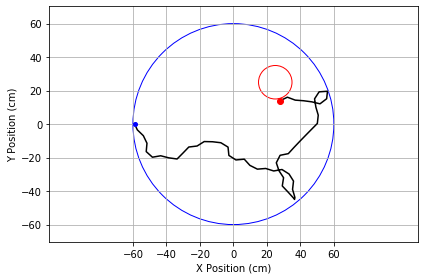

Clever rat, you found the platform in 54 seconds!


In [345]:
# demo of how to use the watermaze module

# create the watermaze object
maze = watermaze()

# set the starting location
maze.startposition()

# run forward for one trial (using random actions for sake of illustration)
while(not maze.timeup() and not maze.atgoal()):
    
    # select a random action - this is what your actor critic network needs to provide
    A = np.random.randint(0,8)
    
    # move the rat
    maze.move(A)
    
# plot the path
maze.plotpath()

# print out why the trial ended (note, if the rat reached the goal, then you must deliver a reward)
if maze.atgoal():
    print("Clever rat, you found the platform in",maze.t,"seconds!")
else:
    print("No more time for you dumb-dumb...")

# The Simulation Class <a name='1'/>

In [409]:
class Simulation:
    '''
    Designed a class to hold both the maze and algorithm, as well as the equations
    necessary to run the simulation.
    Algorithm should either be a string 'actor-critic' or 'combined'
    This cell only contains __init__ because all together looks disgusting
    '''
    def __init__(self,algorithm, eta_a=0.1, eta_c=0.01, eta_xy=0.01, d_f=0.9):
        # *** constant vars ***
        self.N = 493 # number of place cells
        self.sigma = 16 # gaussian width for place cells
        self.Lambda = 0.9 # place cell history in coord model
        
        # *** changing vars ***
        self.goal_xy = [] # goal coordinates
        self.a_c = 0 # preferred action coord
        
        # *** identifiers ***
        self.maze = None
        self.algorithm = algorithm
        
        # *** weights ***
        self.w_c = np.zeros(self.N) # critic weights
        self.w_a = np.zeros([8, self.N]) # actor weights
        self.w_x = np.zeros(self.N) # x-coord weights
        self.w_y = np.zeros(self.N) # y-coord weights
        
        # *** learning ***
        self.eta_a = eta_a # actor learning rate
        self.eta_c = eta_c # critic learning rate
        self.eta_xy = eta_xy # coordinate learning rate
        self.d_f = d_f # discount factor
        
        # *** place cell coordinate generation ***
        self.s = np.zeros([self.N,2])
        self.create_space()
        
        
    # SHOULD BE A PRIVATE FUNCTION BUT ITS PYTHON SO NOT GONNA BOTHER WITH THAT
    def create_space(self,r=60):
        '''
        this function is to create the place cell vectors s_i as needed in the paper.
        '''
        # generate angle and rad
        a = 2*np.pi*np.random.sample(self.N)
        rad = r*np.sqrt(np.random.sample(self.N))
        # create coordinates
        self.s[:,0] = rad*np.cos(a)
        self.s[:,1] = rad*np.sin(a)
        
    
    # **** actor critic policy function ****     
    def activity(self, p):
        '''
        calculates equation (1) in the paper, given the position p.
        '''
        return np.exp(-(np.linalg.norm(p-self.s, axis=1)**2)/(2*(self.sigma**2)))
    
    
    # **** AC POLICY AND STEP ****
    def policy(self, a_j):
        '''
        calculates equation (9) in the paper.
        a_j is the eight possible directions (eight action cells j = 1...8)
        and is stochastically chosen with probabilities P_j calculated.
        '''
        p_j = np.exp(2*a_j)/np.sum(np.exp(2*a_j))
        return np.random.choice(len(p_j), p=p_j)
    
    
    def step(self, A, t):
        '''
        a function for timestep.
        moves in the maze, then gets the new position, then calculates reward.
        Return a tuple with (new position, reward), where reward is a boolean 0 or 1.
        '''
        self.maze.move(A)
        p_new = self.maze.position[:,t+1] 
        return (p_new, 1) if self.maze.atgoal() else (p_new, 0)

    
    # **** OUT FUNCTIONS ****    
    def out_actor(self, p):
        '''
        calculates actor output as stated in the paper. summation across i is equiv to a dot product.
        '''
        return np.dot(self.w_a, self.activity(p))
    
    
    def out_critic(self, p):
        '''
        calculates equation (2) in the paper. summation across i is equiv to a dot product.
        '''
        return np.dot(self.w_c, self.activity(p))
    
    
    def out_x(self, p):
        '''
        x estimate coordinate.
        '''
        return np.dot(self.w_x, self.activity(p))
        
        
    def out_y(self, p):
        '''
        y estimate coordinate.
        '''
        return np.dot(self.w_y, self.activity(p))
    
    
    # **** UPDATE FUNCTIONS ****
    def update_a(self, delta, p, A):
        '''
        calculate equation (10) in the paper. update by incrimentation. 
        delta = temporal difference error.
        '''
        g = np.zeros(8)
        g[A] = 1
        self.w_a += self.eta_a*delta*np.outer(g, self.activity(p))
        
        
    def update_c(self, delta, p):
        '''
        calculate equation (8) in the paper. update by incrimentation.
        '''
        self.w_c += self.eta_c*delta*self.activity(p)
        
        
    def update_a_c(self, delta, const=75):
        '''
        update preferred action coordinate.
        '''
        self.a_c += const*self.eta_a*delta
        
        
    def update_history(self, hist, p):
        '''
        update history of activations.
        '''
        return ((hist*self.Lambda) + self.activity(p))
    
    
    def update_coords(self, p_t, p_new, hist):
        '''
        calculates equation (11) and (12) in the paper.
        '''
        self.w_x += hist*self.eta_xy*(p_t[0]-p_new[0]+self.out_x(p_new)-self.out_x(p_t))
        self.w_y += hist*self.eta_xy*(p_t[1]-p_new[1]+self.out_y(p_new)-self.out_y(p_t))
   

    # **** COORDINATE MODEL FUNCTIONS ****
    def optimal_action(self, x1, x2=np.array([0, 1])):
        '''
        calculate optimal action given a direction vector x1 in the coordinate model.
        '''
        theta = math.atan2(np.linalg.det([x1, x2]), np.dot(x1, x2))
        theta = theta if (theta > 0) else theta + 2*np.pi # workaround
        # reminder to self: action is an int ranging from 0 to 8, and 0&8 are equiv
        return int(round(theta/(np.pi/4)))%8
    
    
    def step_coord(self,p):
        '''
        if a goal position is known, move towards it, else random.
        '''
        if len(self.goal_xy) is not 0:
            x1 = np.subtract(self.goal_xy,[self.out_x(p), self.out_y(p)])
            ans = self.optimal_action(x1)
        else:
            ans = np.random.randint(8)
        return ans
    
    
    # **** SIMULATION FUNCTION ****
    def run_simulation(self):
        '''
        Both follow the same pattern of:
        1) a_j --> A --> p_new and reward
        2) calculate TD error
        3) update model based on TD error and other parameters
        ''' 
        # initialize
        t = 0
        dist = 0
        self.maze.startposition()
        p_t = self.maze.position[:,t]
        
        # *** ACTOR CRITIC MODE ***
        if self.algorithm == 'actor-critic':
            while not (self.maze.atgoal() or self.maze.timeup()):
                # get a_j, A, and from that, p_new and the reward from timestep.
                a_j = self.out_actor(p_t)
                A = self.policy(a_j)
                p_new, reward = self.step(A, t)
                
                # calculate TD error
                TD_error = reward - self.out_critic(p_t) if (reward == 1) else (self.d_f * self.out_critic(p_new))-self.out_critic(p_t)
                
                # update actor and critic weights, distance, position, and time
                self.update_a(TD_error, p_t, A)
                self.update_c(TD_error, p_t)
                dist += np.linalg.norm(p_new-p_t)
                p_t = p_new
                t += 1
            return (t, dist)
        
        # *** COMBINED MODE ***
        if self.algorithm == 'combined':
            history = np.zeros(self.N)
            while not (self.maze.atgoal() or self.maze.timeup()):
                flag_a = False
                # append the preferred action/coordinate to a_j. Timestep. 
                a_j = np.append(self.out_actor(p_t), self.a_c)
                A = self.policy(a_j)
                # calculate coordinate model step if selected
                if A == 8:
                    A = self.step_coord(p_t)
                    flag_a = True
                p_new, reward = self.step(A, t)
                
                # calculate TD error
                TD_error = reward - self.out_critic(p_t) if (reward == 1) else (self.d_f * self.out_critic(p_new))-self.out_critic(p_t)
                
                # update history
                history = self.update_history(history, p_t)
                self.update_c(TD_error, p_t)
                self.update_coords(p_t, p_new, history) 
                # update coordinate & actor weights depending on situation & others
                if (flag_a and (len(self.goal_xy) != 0)):
                    self.update_a_c(TD_error)
                else:
                    self.update_a(TD_error, p_t, A)
                dist += np.linalg.norm(p_new-p_t)
                p_t = p_new
                t += 1
                # update goal xy if necessary
                self.goal_xy = [self.out_x(p_t), self.out_y(p_t)] if (reward == 1) else []
            return (t, dist)

### Update Functions

SO I DONT FORGET:

f_i(p_i)*g_j(t) == outer(f_i(p_i), g_j(t))

https://numpy.org/doc/stable/reference/generated/numpy.outer.html

### Coordinate model functions

When I forget, see:

https://numpy.org/doc/stable/reference/generated/numpy.arctan2.html

https://stackoverflow.com/questions/35749246/python-atan-or-atan2-what-should-i-use

# Experiments <a name='4'/>
Note: Originally tried graphing both time and length, they basically both show the exact same data. So chose to show the latter plots as to me, using distance is more appealing.

This can easily be interchanged to graphing time by changing the data_d --> data_t and mean_d --> mean_t

### Multi-Platform Flag

In [416]:
MP_flag = True # flag for single or multi-platform cases
# locations are arbitrary for debug purposes
#platform_coords = random.randint(-60, 60, size=(5,2))
platform_coords = [[15,15], [-15,-15], [30,10], [-10, 30], [-40,20]]
platforms = np.array(platform_coords) if MP_flag else np.array(platform_coords[0])
n_p = len(platforms) if MP_flag else 1

### PART 2: ACTOR-CRITIC

In [394]:
# *** initialize variables ***
# assuming TA expects equal total runs for multi and singular (40 total in exp.)
n_t = 50 # number of trials
runs = 10 if MP_flag else 50
dim_ini = [runs, n_p*n_t] # initialized dimension of data
data_t = np.zeros(dim_ini) # time
data_d = np.zeros(dim_ini) # distance
algorithm = 'actor-critic' # 'actor-critic' or 'combined'

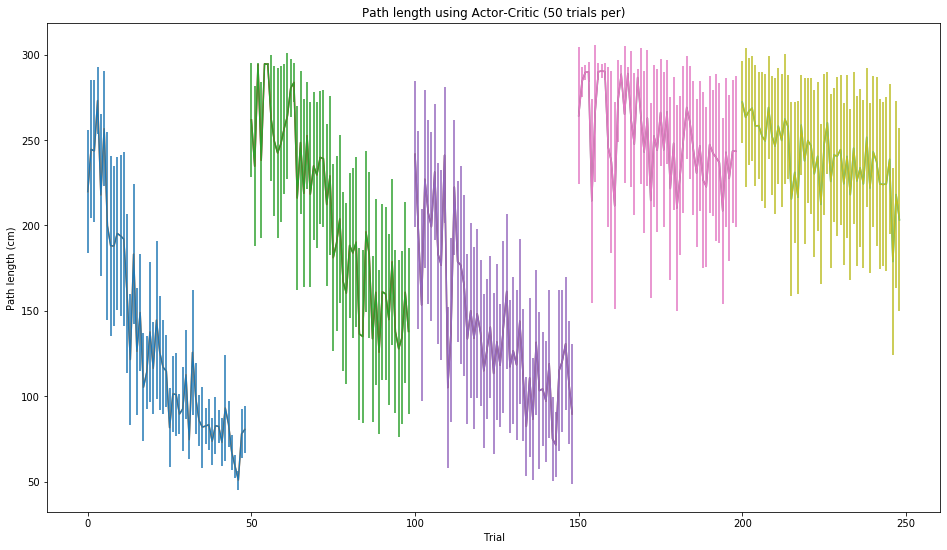

In [395]:
# get data from each timestep
n_runs = np.arange(runs)
for run in n_runs:
    # the model with the selected algorithm
    model = Simulation(algorithm)
    for i in range(n_p):
        for j in range(n_t):
            i_maze = watermaze(platform_location=platforms[i])
            model.maze = i_maze
            time, dist = model.run_simulation()
            data_t[run, (i*n_t)+j] = time
            data_d[run, (i*n_t)+j] = dist
            
# mean calculations, time data can be used as well just by replacing the end tag char from d to t's.pain 
mean_t = np.mean(data_t, axis=0)
mean_d = np.mean(data_d, axis=0)
std_t = np.std(data_t, axis=0)
std_d = np.std(data_d, axis=0)

# plotting
plt.figure(figsize=(16,9)) # screen aspect ratio

if MP_flag:
    des_ranges = [[0, 49],[50, 99],[100, 149],[150, 199],[200, 249]] # note this would change if n_t changes
    for ran in des_ranges:
        xPartition = np.arange(ran[0], ran[1])
        yPartition = mean_d[ran[0]: ran[1]]
        plt.errorbar(xPartition, yPartition, std_d[ran[0]: ran[1]]/2)
        plt.plot(xPartition,yPartition)
else:
    x_vals = np.arange(len(mean_d))
    plt.errorbar(x_vals, mean_d, std_d/2)
    plt.plot(x_vals, mean_d)

plt.title(f'Path length using Actor-Critic ({n_t} trials per)')
plt.xlabel('Trial')
plt.ylabel('Path length (cm)')
plt.show()

### Part 3: Combined Model

In [410]:
# *** initialize variables ***
n_t = 50 # number of trials
runs = 10 if MP_flag else 50
dim_ini = [runs, n_p*n_t] # initialized dimension of data
data_t = np.zeros(dim_ini) # time
data_d = np.zeros(dim_ini) # distance
algorithm = 'combined' # 'actor-critic' or 'combined'

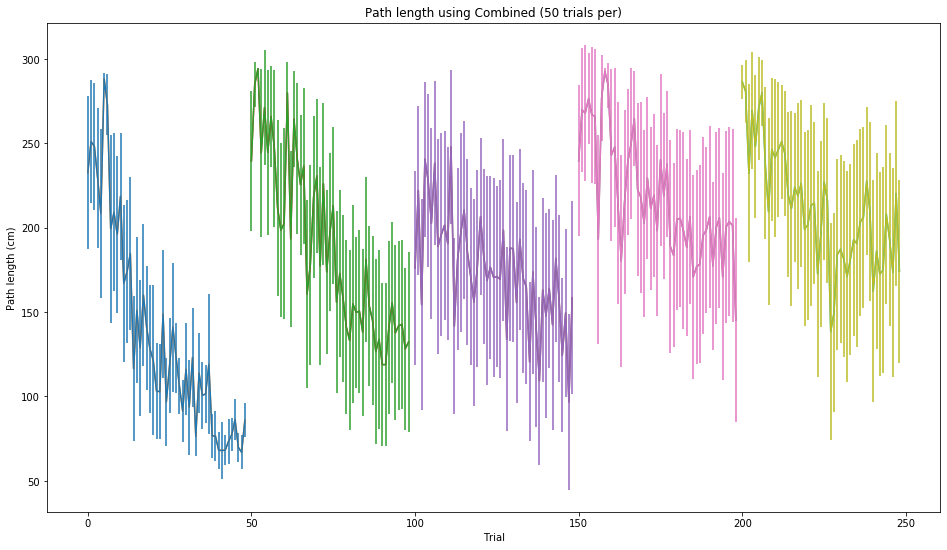

In [411]:
# get data from each timestep
n_runs = np.arange(runs)
for run in n_runs:
    # the model with the selected algorithm
    model = Simulation(algorithm, d_f=0.80)
    for i in range(n_p):
        for j in range(n_t):
            i_maze = watermaze(platform_location=platforms[i])
            model.maze = i_maze
            time, dist = model.run_simulation()
            data_t[run, (i*n_t)+j] = time
            data_d[run, (i*n_t)+j] = dist
            
# mean calculations
mean_t = np.mean(data_t, axis=0)
mean_d = np.mean(data_d, axis=0)
std_t = np.std(data_t, axis=0)
std_d = np.std(data_d, axis=0)

# plotting
plt.figure(figsize=(16,9))

if MP_flag:
    des_ranges = [[0, 49],[50, 99],[100, 149],[150, 199],[200, 249]] # would change according to n_t
    for ran in des_ranges:
        xPartition = np.arange(ran[0], ran[1])
        yPartition = mean_d[ran[0]: ran[1]]
        plt.errorbar(xPartition, yPartition, std_d[ran[0]: ran[1]]/2)
        plt.plot(xPartition,yPartition)
else:
    x_vals = np.arange(len(mean_d))
    plt.errorbar(x_vals, mean_d, std_d/2)
    plt.plot(x_vals, mean_d)

plt.title(f'Path length using Combined ({n_t} trials per)')
plt.xlabel('Trial')
plt.ylabel('Path length (cm)')
plt.show()

## Using Seconds (escape latency)
As seen below, it look exactly the same as distance. Thus did not feel the need to include it in the assignment report.

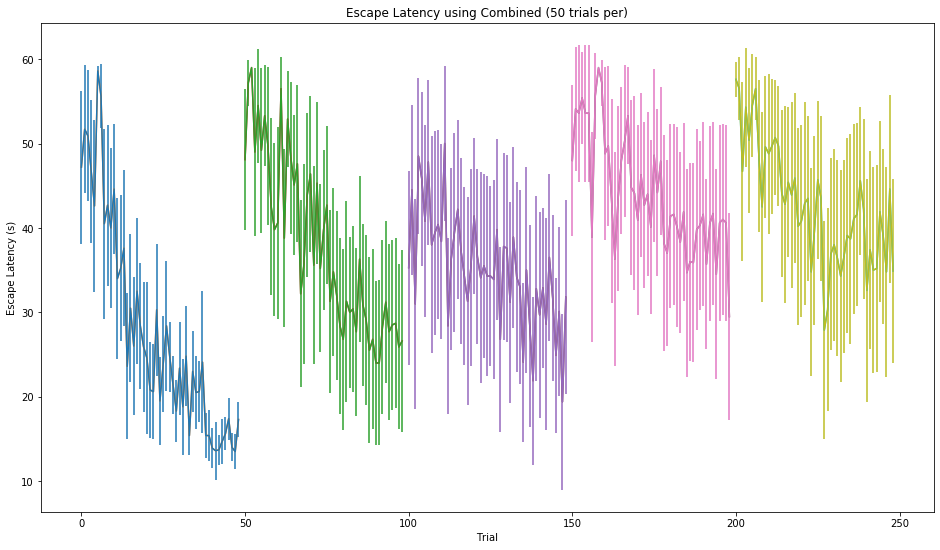

In [412]:
# plotting
plt.figure(figsize=(16,9))

if MP_flag:
    des_ranges = [[0, 49],[50, 99],[100, 149],[150, 199],[200, 249]] # would change according to n_t
    for ran in des_ranges:
        xPartition = np.arange(ran[0], ran[1])
        yPartition = mean_t[ran[0]: ran[1]]
        plt.errorbar(xPartition, yPartition, std_t[ran[0]: ran[1]]/2)
        plt.plot(xPartition,yPartition)
else:
    x_vals = np.arange(len(mean_t))
    plt.errorbar(x_vals, mean_t, std_t/2)
    plt.plot(x_vals, mean_t)

plt.title(f'Escape Latency using Combined ({n_t} trials per)')
plt.xlabel('Trial')
plt.ylabel('Escape Latency (s)')
plt.show()